# Multiclass classification with logistic regression

Working with Car Evaluation [dataset](https://archive.ics.uci.edu/ml/datasets/car+evaluation). The task is to predict the auto class based on its characteristics. Auto class could be one of: unacceptable, acceptable, good, very good.

Dataset will be fetched using the API.

In [1]:
import graphviz
import pydotplus
import warnings

import numpy as np
import pandas as pd
import seaborn as sns

from pathlib import Path
from six import StringIO
from IPython.display import Image
from ucimlrepo import fetch_ucirepo 

from matplotlib import pyplot as plt

from sklearn.tree import export_graphviz, DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.pipeline import Pipeline


warnings.filterwarnings('ignore')
%matplotlib inline

Fetch Car Evaluetion dataset

In [2]:
car_evaluation = fetch_ucirepo(id=19) 
  
X = car_evaluation.data.features 
y = car_evaluation.data.targets

In [3]:
df = pd.concat([X, y], axis=1)
df.index += 1
df.head()

,buying,maint,doors,persons,lug_boot,safety,class
1,vhigh,vhigh,2,2,small,low,unacc
2,vhigh,vhigh,2,2,small,med,unacc
3,vhigh,vhigh,2,2,small,high,unacc
4,vhigh,vhigh,2,2,med,low,unacc
5,vhigh,vhigh,2,2,med,med,unacc


Getting the statistics regarding the number of unique values of each unbound feature

In [4]:
count_unbound_vars = {col: X[col].value_counts().to_dict() for col in X.columns}
count_unbound_vars

{'buying': {'vhigh': 432, 'high': 432, 'med': 432, 'low': 432},
 'maint': {'vhigh': 432, 'high': 432, 'med': 432, 'low': 432},
 'doors': {'2': 432, '3': 432, '4': 432, '5more': 432},
 'persons': {'2': 576, '4': 576, 'more': 576},
 'lug_boot': {'small': 576, 'med': 576, 'big': 576},
 'safety': {'low': 576, 'med': 576, 'high': 576}}

Getting statistics for target variable. This is an ordinal variable because its values (the degree of "acceptability" of a car) can be naturally arranged in ascending/descending order and labeled. The classification is unbalanced due to the obvious presence of a majority (unacc) and a minority (good, vgood) classes

In [5]:
y.value_counts()

class
unacc    1210
acc       384
good       69
vgood      65
Name: count, dtype: int64

Checking for N/A values

In [6]:
df.isna().sum()

buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
class       0
dtype: int64

Splitting unbound and target data into train and test samples in proportion = 66/33

In [7]:
test_size = 0.33
X_train_df, X_test_df, y_train, y_test = train_test_split (X, y, test_size = test_size, shuffle = True, random_state=42) 

View data samples

In [8]:
X_train_df.shape, X_test_df.shape

((1157, 6), (571, 6))

In [9]:
X_train_df.head()

,buying,maint,doors,persons,lug_boot,safety
48,vhigh,vhigh,3,more,med,low
468,high,vhigh,3,4,small,low
155,vhigh,high,3,more,small,high
1721,low,low,5more,more,small,high
1208,med,low,2,more,small,high


In [10]:
X_test_df.head()

,buying,maint,doors,persons,lug_boot,safety
599,high,high,4,2,med,high
1201,med,low,2,4,med,med
628,high,high,5more,2,big,med
1498,low,high,5more,4,med,med
1263,med,low,4,more,med,low


In [11]:
display(X_train_df.dtypes, X_test_df.dtypes)

buying      object
maint       object
doors       object
persons     object
lug_boot    object
safety      object
dtype: object

buying      object
maint       object
doors       object
persons     object
lug_boot    object
safety      object
dtype: object

Encoding of all ordinal variables using sklearn.preprocessing.OrdinalEncoder. The encoded values are sorted in ascending order.

In [12]:
buying_cat = X[X.columns[0]].unique().tolist()[::-1]
maint_cat = X[X.columns[1]].unique().tolist()[::-1]
doors_cat = X[X.columns[2]].unique().tolist()
persons_cat = X[X.columns[3]].unique().tolist()
lug_boot_cat = X[X.columns[4]].unique().tolist()
safety_cat = X[X.columns[5]].unique().tolist()

In [13]:
enc_categories = [buying_cat, maint_cat, doors_cat, persons_cat, lug_boot_cat, safety_cat]

ordinal_encoder = OrdinalEncoder(categories=enc_categories)

ordinal_encoder.fit(X_train_df)

X_train = ordinal_encoder.transform(X_train_df)
X_test = ordinal_encoder.transform(X_test_df)

In [14]:
X_train[:5], X_test[:5]

(array([[3., 3., 1., 2., 1., 0.],
        [2., 3., 1., 1., 0., 0.],
        [3., 2., 1., 2., 0., 2.],
        [0., 0., 3., 2., 0., 2.],
        [1., 0., 0., 2., 0., 2.]]),
 array([[2., 2., 2., 0., 1., 2.],
        [1., 0., 0., 1., 1., 1.],
        [2., 2., 3., 0., 2., 1.],
        [0., 2., 3., 1., 1., 1.],
        [1., 0., 2., 2., 1., 0.]]))

6.3.Выведите полученные категории энкодера.

In [15]:
ordinal_encoder.categories_

[array(['low', 'med', 'high', 'vhigh'], dtype=object),
 array(['low', 'med', 'high', 'vhigh'], dtype=object),
 array(['2', '3', '4', '5more'], dtype=object),
 array(['2', '4', 'more'], dtype=object),
 array(['small', 'med', 'big'], dtype=object),
 array(['low', 'med', 'high'], dtype=object)]

Training the logistic regression model on encoded train data samples.

In [16]:
log_r = LogisticRegression(random_state=42).fit(X_train, y_train)

Making predictions

In [17]:
train_predict = log_r.predict(X_train)
test_predict = log_r.predict(X_test)

Getting quality metrics with classification_report

In [18]:
print(f"Train set:\n{classification_report(y_train, train_predict)}\n")
print(f"Test set:\n{classification_report(y_test, test_predict)}")

Train set:
              precision    recall  f1-score   support

         acc       0.66      0.58      0.61       255
        good       0.53      0.39      0.45        49
       unacc       0.88      0.93      0.90       813
       vgood       0.79      0.65      0.71        40

    accuracy                           0.82      1157
   macro avg       0.71      0.64      0.67      1157
weighted avg       0.81      0.82      0.81      1157


Test set:
              precision    recall  f1-score   support

         acc       0.65      0.58      0.61       129
        good       0.55      0.30      0.39        20
       unacc       0.88      0.93      0.90       397
       vgood       0.78      0.72      0.75        25

    accuracy                           0.82       571
   macro avg       0.71      0.63      0.66       571
weighted avg       0.81      0.82      0.81       571



Plotting the confusion matrix

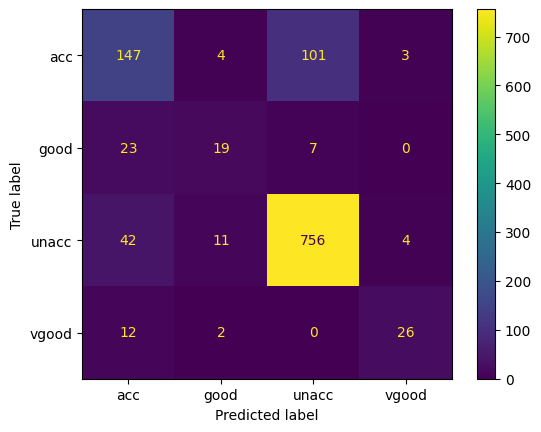

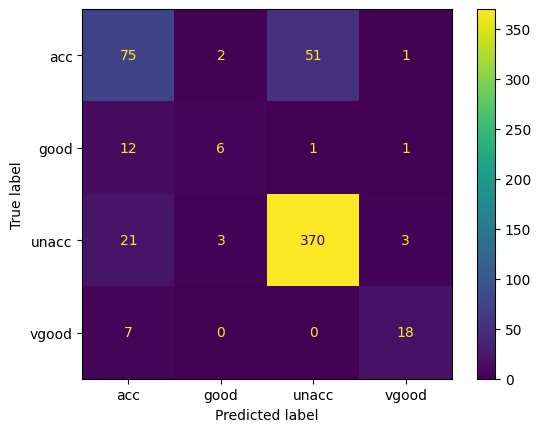

In [19]:
cm_train = confusion_matrix(y_train, train_predict) 
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=log_r.classes_)

cm_test = confusion_matrix(y_test, test_predict) 
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=log_r.classes_)

disp_train.plot()
disp_test.plot()

plt.show()

**The Weighted f-score is preferable to use for comparison of the different models - due to the fact that the classes are unbalanced; f-score - because it balances precision and recall. Thus, this metric value is 0.82 for both test and training samples**

# Multiclass classification with logistic Decision Tree

Training the Decision Tree from sklearn with depth 4 on the same data. Calculation the predictions. Finding the quality metric on the test data. Comparison with logistic regression.

In [20]:
tree_clf = DecisionTreeClassifier(random_state=42, max_depth=4).fit(X_train, y_train)

In [21]:
tree_train_predict = tree_clf.predict(X_train)
tree_test_predict = tree_clf.predict(X_test)

In [22]:
print(classification_report(y_train, tree_train_predict))
print(classification_report(y_test, tree_test_predict))

              precision    recall  f1-score   support

         acc       0.68      0.89      0.77       255
        good       0.53      0.69      0.60        49
       unacc       0.97      0.91      0.94       813
       vgood       0.00      0.00      0.00        40

    accuracy                           0.87      1157
   macro avg       0.55      0.62      0.58      1157
weighted avg       0.86      0.87      0.86      1157

              precision    recall  f1-score   support

         acc       0.68      0.79      0.73       129
        good       0.38      0.60      0.46        20
       unacc       0.96      0.94      0.95       397
       vgood       0.00      0.00      0.00        25

    accuracy                           0.85       571
   macro avg       0.50      0.58      0.54       571
weighted avg       0.83      0.85      0.84       571



**We compare according to the indicator weighted f-score. Both models - logistic regression and DT - show almost the same quality (0.81 for logistic regression and 0.84 for DT). Although, if we consider the accuracy and coverage indicators for each category separately, then DT gives significantly better results (with the exception of the vgood category).**
  
**Disadvantages of DT: with the given parameters, the vgood class was not identified at all. In addition, with 100% coverage, the forecast accuracy for the good category is too low.**

In [23]:
tree_clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

Visualization of the resulting decision tree

In [24]:
dot_data = export_graphviz(tree_clf,
                           out_file=None,
                           filled=True,
                           rounded=True,
                           special_characters=True,
                           feature_names=X.columns.tolist(),
                           class_names=['unacc', 'acc', 'vgood', 'good'])

graph = graphviz.Source(dot_data)

Search for hyperparameters for DecisionTree on a grid using sklearn. Set the grid of parameters based on assumptions that can improve the performance of the tree.

In [27]:
dt = DecisionTreeClassifier(random_state=42)
param_grid = {'criterion': ['gini', 'entropy'],
              'splitter': ['best', 'random'],
              'max_depth': np.arange(4,8,1),
              'max_leaf_nodes':[4,8,16,32],
              'max_features': ['sqrt', 'log2', None]
             }

search = GridSearchCV(dt, param_grid, cv = 5)

In [28]:
search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([4, 5, 6, 7]),
                         'max_features': ['sqrt', 'log2', None],
                         'max_leaf_nodes': [4, 8, 16, 32],
                         'splitter': ['best', 'random']})

Making predict based on found hyperparams

In [29]:
best_model = search.best_estimator_
best_model_predict = best_model.predict(X_test)

Claasification report of the found model. The rates are much better then of the default DT model

In [31]:
print(classification_report(y_test, best_model_predict))

              precision    recall  f1-score   support

         acc       0.85      0.82      0.83       129
        good       0.52      0.70      0.60        20
       unacc       0.98      0.97      0.97       397
       vgood       0.79      0.88      0.83        25

    accuracy                           0.92       571
   macro avg       0.78      0.84      0.81       571
weighted avg       0.93      0.92      0.92       571



Confusion matrix for hyperparams model

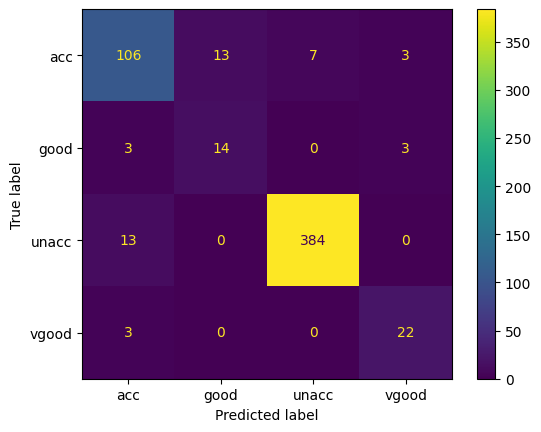

In [32]:
best_model_cm = confusion_matrix(y_test, best_model_predict)
disp_best_model = ConfusionMatrixDisplay(confusion_matrix=best_model_cm, display_labels=best_model.classes_)

disp_best_model.plot()

plt.show()